In [4]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, f1_score, recall_score,classification_report, precision_score
from catboost import CatBoostClassifier, Pool

In [5]:
df = pd.read_csv("churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
dropable = ['CustomerId', 'RowNumber', 'Surname']
df = df.drop(columns=dropable)
display(df)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [7]:
#split the data

target = ['Exited']
cat_var = ['Geography', 'Gender', 'IsActiveMember', 'HasCrCard']

X = df.drop(target, axis=1)
Y = df['Exited']

X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

In [8]:
display(Y_train)

2151    1
8392    1
5006    0
4117    0
7182    0
       ..
4555    1
4644    0
8942    0
2935    0
6206    0
Name: Exited, Length: 8000, dtype: int64

In [9]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8000, 10), (2000, 10), (8000,), (2000,))

In [10]:
cat_feat = [X.columns.get_loc(col) for col in cat_var]
display(cat_feat) 

[1, 2, 8, 7]

In [11]:
model = CatBoostClassifier(
    iterations=700,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    loss_function='Logloss',
    cat_features=cat_feat,
    verbose=100,
    random_seed=42
)

model.fit(X_train, Y_train, eval_set=(X_test, Y_test), early_stopping_rounds=50)

0:	test: 0.8265639	best: 0.8265639 (0)	total: 178ms	remaining: 2m 4s
100:	test: 0.8744831	best: 0.8744831 (100)	total: 3.02s	remaining: 17.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8750645869
bestIteration = 117

Shrink model to first 118 iterations.


In [12]:
train_pool = Pool(X_train, Y_train, cat_features=cat_var)
test_pool = Pool(X_test, Y_test, cat_features=cat_var)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

0:	test: 0.8265639	best: 0.8265639 (0)	total: 29.1ms	remaining: 20.4s
100:	test: 0.8744831	best: 0.8744831 (100)	total: 2.95s	remaining: 17.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8750645869
bestIteration = 117

Shrink model to first 118 iterations.


In [13]:
y_pred = model.predict(X_test)
print (classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.81      0.47      0.60       407

    accuracy                           0.87      2000
   macro avg       0.85      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000

[[1549   44]
 [ 215  192]]


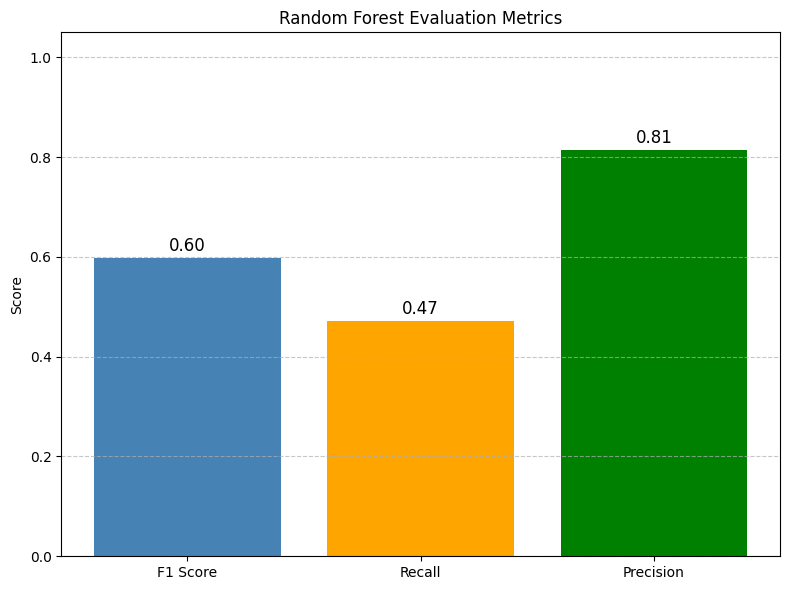

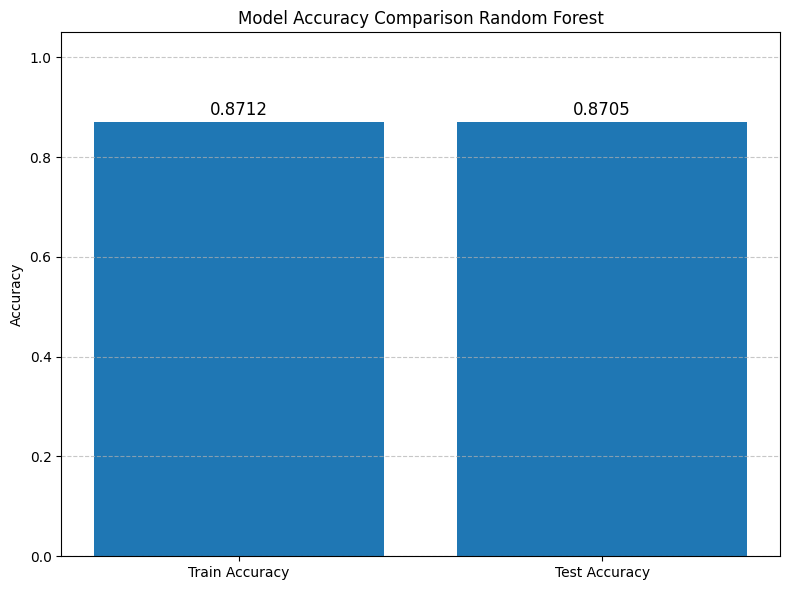

In [19]:
#model evaluation
cat_pred = model.predict(X_test)
# Calculate metrics
f1 = f1_score(Y_test, cat_pred, pos_label=1)
recall = recall_score(Y_test, cat_pred, pos_label=1)
precision = precision_score(Y_test, cat_pred)

# Data for bar chart
metrics = ['F1 Score', 'Recall', 'Precision']
values = [f1, recall, precision]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['steelblue', 'orange', 'green'])

# Annotate each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', fontsize=12)

plt.ylim(0, 1.05)
plt.title("Random Forest Evaluation Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Accuracy comparison
# Training and Testing Accuracy
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
train_accuracy = accuracy_score(Y_train, pred_train)
test_accuracy = accuracy_score(Y_test, pred_test) 
metrics = ['Train Accuracy', 'Test Accuracy']
values = [train_accuracy, test_accuracy]

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values)

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.4f}", 
                 xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 5),  # 5 points vertical offset
                 textcoords="offset points", 
                 ha='center', fontsize=12)

plt.ylim(0, 1.05)
plt.title("Model Accuracy Comparison Random Forest")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()